In [1]:
import pandas as pd
import matplotlib.pyplot as plt

metadata = pd.read_csv('full_english_metadata.csv')

In [2]:
metadata.head()

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves,Author_Name,Author_Dates,Era
0,1,Text,1971-12-01,The Declaration of Independence of the United ...,en,"Jefferson, Thomas, 1743-1826","United States -- History -- Revolution, 1775-1...",E201; JK,Politics; American Revolutionary War; United S...,Jefferson,1743-1826,1700s
1,3,Text,1973-11-01,John F. Kennedy's Inaugural Address,en,"Kennedy, John F. (John Fitzgerald), 1917-1963",United States -- Foreign relations -- 1961-196...,E838,Browsing: History - American; Browsing: Politics,Kennedy,1917-1963,1900s
2,4,Text,1973-11-01,Lincoln's Gettysburg Address\r\nGiven November...,en,"Lincoln, Abraham, 1809-1865",Consecration of cemeteries -- Pennsylvania -- ...,E456,US Civil War; Browsing: History - American; Br...,Lincoln,1809-1865,1800s
3,6,Text,1976-12-01,Give Me Liberty or Give Me Death,en,"Henry, Patrick, 1736-1799","Speeches, addresses, etc., American; United St...",E201,American Revolutionary War; Browsing: History ...,Henry,1736-1799,1700s
4,8,Text,1978-12-01,Abraham Lincoln's Second Inaugural Address,en,"Lincoln, Abraham, 1809-1865",United States -- Politics and government -- 18...,E456,US Civil War; Browsing: History - American; Br...,Lincoln,1809-1865,1800s


## Cleaning

In [3]:
# Create mapping of book_id to publication_year
id_to_year = dict(zip(metadata['Text#'], metadata['Era']))

In [4]:
import os
import random
import re
from collections import defaultdict
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pathlib import Path

In [5]:
# # Define eras
# ERA_RANGES = [(1400, 1499), (1500, 1599), (1600, 1699), (1700, 1799), (1800, 1899), (1900, 1999)]
# ERA_LABELS = ['1400s', '1500s', '1600s', '1700s', '1800s', '1900s']

# def extract_middle_excerpt(text, window=1000):
#     middle = len(text) // 2
#     start = max(0, middle - window // 2)
#     end = start + window
#     return text[start:end]

# def build_dataset_from_metadata(metadata_df, text_dir, samples_per_era=1000, window=1000):
#     era_buckets = defaultdict(list)
    
#     for _, row in metadata_df.iterrows():
#         text_number = int(row['Text#'])
#         era = row['Era']

#         text_path = os.path.join(text_dir, str(text_number), f"pg{text_number}.txt")
#         if not os.path.isfile(text_path):
#             continue

#         try:
#             with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
#                 content = f.read()
#             if len(content) < window:
#                 continue
#             excerpt = extract_middle_excerpt(content, window)
#             era_buckets[era].append({'text': excerpt, 'text_number': text_number, 'label': era})
#         except Exception as e:
#             print(f"Error reading {text_path}: {e}")
#             continue

#     # Uniform sampling
#     dataset = []
#     for era, entries in era_buckets.items():
#         if len(entries) >= samples_per_era:
#             dataset.extend(random.sample(entries, samples_per_era))
#         else:
#             print(f"Warning: Only {len(entries)} excerpts found for era {era}")
#             dataset.extend(entries)
#     random.shuffle(dataset)
#     return dataset


In [6]:
# from tqdm import tqdm
# from multiprocessing import Pool, cpu_count
# from collections import defaultdict
# from pathlib import Path
# import random
# import os

# def extract_middle_sentences(text, num_sentences=5):
#     from nltk.tokenize import sent_tokenize
#     sentences = sent_tokenize(text)
#     if len(sentences) < num_sentences:
#         return None, None, None

#     middle = len(sentences) // 2
#     start = max(0, middle - num_sentences // 2)
#     end = start + num_sentences
#     return ' '.join(sentences[start:end]), sentences, end


# def process_single_file_minimal(args):
#     row, text_dir = args
#     text_number = int(row['Text#'])
#     era = row['Era']
#     text_path = Path(text_dir) / str(text_number) / f"pg{text_number}.txt"

#     if not text_path.exists():
#         return None

#     try:
#         with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
#             content = f.read()

#         excerpt, _, _ = extract_middle_sentences(content)
#         if not excerpt:
#             return None

#         return {
#             'era': era,
#             'text_number': text_number,
#             'excerpt': excerpt,
#         }

#     except Exception as e:
#         print(f"Error processing {text_path}: {e}")
#         return None


# def build_dataset_memory_safe(metadata_df, text_dir, samples_per_era=1000):
#     era_entries = defaultdict(list)
#     args = [(row, text_dir) for _, row in metadata_df.iterrows()]

#     with Pool(cpu_count()) as pool:
#         for result in tqdm(pool.imap_unordered(process_single_file_minimal, args, chunksize=10), total=len(args)):
#             if result is None:
#                 continue
#             era = result['era']
#             if len(era_entries[era]) < samples_per_era:
#                 era_entries[era].append({
#                     'text': result['excerpt'],
#                     'text_number': result['text_number'],
#                     'label': era
#                 })

#     # Compile dataset
#     dataset = []
#     for era, entries in era_entries.items():
#         dataset.extend(entries)

#     random.shuffle(dataset)
#     return dataset


In [7]:
def extract_random_sentences(text, num_sentences=5):
    text = text.replace('\n', ' ')
    sentences = sent_tokenize(text)

    if len(sentences) < num_sentences:
        return None

    mid_start = len(sentences) // 4
    mid_end = (3 * len(sentences)) // 4 - num_sentences
    if mid_end <= mid_start:
        start = mid_start
    else:
        start = random.randint(mid_start, mid_end)

    end = start + num_sentences
    return ' '.join(sentences[start:end])

def extract_random_char_excerpt(text, min_chars=400, max_chars=600):
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()

    if len(text) < min_chars:
        return None

    # Middle half range
    quarter = len(text) // 4
    three_quarters = (3 * len(text)) // 4
    max_start = max(quarter, three_quarters - max_chars)

    if max_start <= quarter:
        start = quarter
    else:
        start = random.randint(quarter, max_start)

    end = min(start + random.randint(min_chars, max_chars), len(text))

    excerpt = text[start:end]

    # Avoid cutting off in the middle of a word
    excerpt = re.sub(r'^\S*\s', '', excerpt)  # trim partial word at start
    excerpt = re.sub(r'\s\S*$', '', excerpt)  # trim partial word at end

    return excerpt if len(excerpt) >= min_chars else None


def extract_main_gutenberg_text(content):
    # Extract text between START and END markers
    start_match = re.search(r"\*\*\*\s*START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*", content, re.IGNORECASE)
    end_match = re.search(r"\*\*\*\s*END OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*", content, re.IGNORECASE)

    if start_match and end_match:
        return content[start_match.end():end_match.start()]
    else:
        return content  # fallback to full text if markers not found


def process_single_file_multiple_excerpts(args):
    row, text_dir, repeats = args
    text_number = int(row['Text#'])
    era = row['Era']
    text_path = Path(text_dir) / str(text_number) / f"pg{text_number}.txt"

    if not text_path.exists():
        return []

    try:
        with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()

        main_text = extract_main_gutenberg_text(content)
        excerpts = []

        for _ in range(repeats):
            excerpt = extract_random_char_excerpt(main_text)
            if excerpt:
                excerpts.append({
                    'era': era,
                    'text_number': text_number,
                    'excerpt': excerpt,
                })

        return excerpts

    except Exception as e:
        print(f"Error processing {text_path}: {e}")
        return []

def build_dataset_with_resampling(metadata_df, text_dir, samples_per_era=1000, num_sentences=5):
    from math import ceil

    # Group metadata by era
    era_to_rows = defaultdict(list)
    for _, row in metadata_df.iterrows():
        era_to_rows[row['Era']].append(row)

    era_entries = defaultdict(list)

    for era, rows in era_to_rows.items():
        n_texts = len(rows)
        if n_texts == 0:
            continue

        repeats_per_file = ceil(samples_per_era / n_texts)
        args = [(row, text_dir, repeats_per_file) for row in rows]

        with Pool(cpu_count()) as pool:
            for result_list in tqdm(pool.imap_unordered(process_single_file_multiple_excerpts, args, chunksize=10), total=len(args)):
                for result in result_list:
                    if len(era_entries[era]) < samples_per_era:
                        era_entries[era].append({
                            'text': result['excerpt'],
                            'text_number': result['text_number'],
                            'label': era
                        })
                    if len(era_entries[era]) >= samples_per_era:
                        break

    # Compile final dataset
    dataset = []
    for era, entries in era_entries.items():
        dataset.extend(entries)

    random.shuffle(dataset)
    return dataset


I believe we are going to want 5,000–10,000 total samples, since this is standard for BERT/Transformer models. 80% training, 10% validation, 10% test set split

In [8]:
dataset = build_dataset_with_resampling(metadata, 'cache/epub', samples_per_era=1000)
uniform_excerpts_df = pd.DataFrame(dataset)

100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


In [9]:
uniform_excerpts_df.head()

,text,text_number,label
0,"seen that my intention was, to shew them that ...",15469,1700s
1,"the spectacle. Mrs. Charmond did not see them,...",482,1800s
2,King and the ladies of the Court rode out to t...,467,1600s
3,"assembly, he had published a letter, in which ...",1346,1800s
4,"some moan. '""Lo, all these trophies of affecti...",1137,1500s


In [10]:
uniform_excerpts_df.shape

(5949, 3)

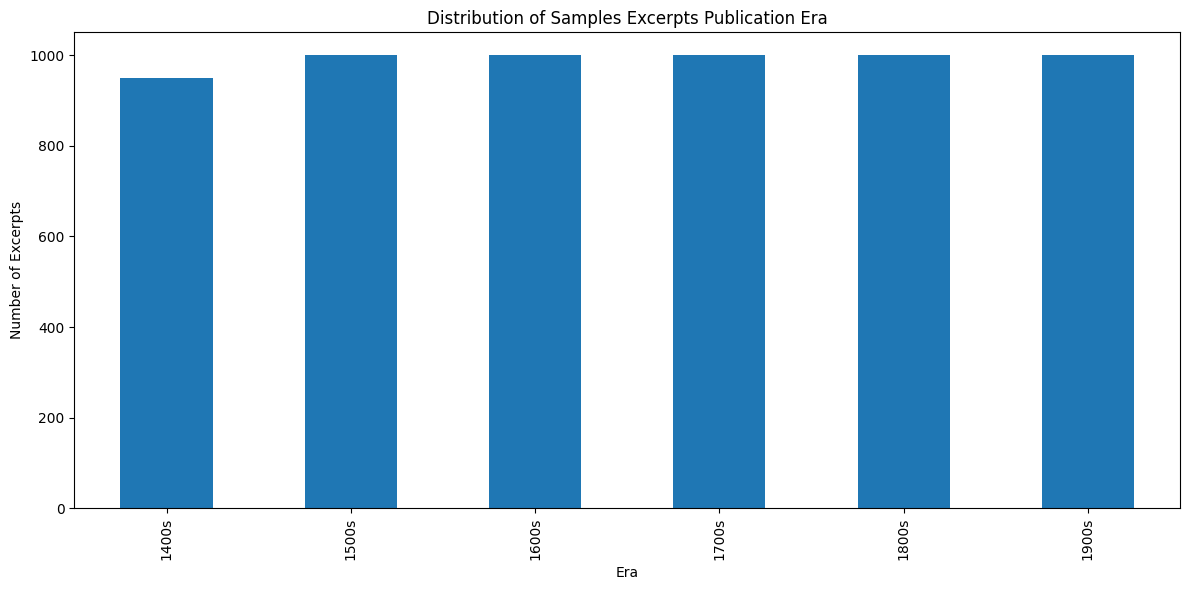

In [11]:
plt.figure(figsize=(12, 6))
era_counts = uniform_excerpts_df["label"].value_counts().sort_index()
era_counts.plot(kind='bar')

plt.title('Distribution of Samples Excerpts Publication Era')
plt.xlabel('Era')
plt.ylabel('Number of Excerpts')

plt.tight_layout()
plt.show()

In [16]:
uniform_excerpts_df[uniform_excerpts_df['label']=='1400s']

,text,text_number,label
5,to pass. And thus upon trust of your short rep...,32155,1400s
10,"haue a manne. Eulalia. wel, what and thou coud...",14282,1400s
16,"nat, althoghe he had redde hys bokes, how he c...",14746,1400s
25,"examined them, Mr. Bell being present; which h...",32155,1400s
29,you what is the matter you murmour so with you...,16246,1400s
...,...,...,...
5899,"you have as yet felt nothing, I hope, and am a...",32155,1400s
5905,"& to be honoryd, bycause the other was shauen ...",14746,1400s
5912,the hand of him which I would were yours. H. R...,32155,1400s
5921,"_Naymura_, to which places he steered his cour...",20321,1400s


In [17]:
#uniform_excerpts_df.to_csv('uniform_excerpts_2.csv', index=False)